# Classes and functions to build NN's with different features for testing
Structure: Inputlayer-(FCL-ActivationLayer)-(FCL-ActivationLayer)...(FCL-ActivationLayer)-OutputLayer

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
np.random.seed(1)
tensorflow.random.set_seed(1)
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, f1_score

 ## Class for layer

In [3]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

## Class for fully connected layer

### Forward propagation method:

#### Input: 
$\underline{x}$ - ROW vector of size $1 $ x $i$  
    
#### output of one layer:  
  
$ \underline{y} =  \underline{x \cdot W} + \underline{b}  $ - vector of size $j$ x $1$

#### Used:
     
Weights: $W$ - matrix of size $i$ x $j$  
bias: $ \underline{b} $ COLUMN vector of length $j$ x $1$. One $b_j$ for each $y_j$   

### Backward porpagation method:  
  
#### Input:  
    
$\underline{output\_error} = \frac{d\underline{E}}{d\underline{y}} $ is a vector, of shape $1$ x $j$, with elements $\frac{d\underline{E}}{d\underline{y_j}}$  
  
LearningRate $ \alpha $  
  
$E$ is the loss function, calculated as (in class ...)  
  

#### Output:  
  
Weights_error = $ \frac{d\underline{E}}{d\underline{W}} = \underline{x}^T \cdot \frac{d\underline{E}}{d\underline{y}} $ is a matrix of size $i$ x $j$  

#### Used:
  
$\underline{bias\_error} = output\_error$ - vector length $1$ x $b$    
  
$ \underline{input\_error}: \frac{d\underline{E}}{d\underline{x}} = \frac{d\underline{E}}{d\underline{y}} \cdot W^T $ - vector of size $1$ x $i$ 
  
derivation on paper.


In [4]:
class FCLayer():
    # input_size (i) = number of input neurons
    # output_size (j) = number of output neurons
    def __init__(self, input_size, output_size):
        #start by setting random weights and biases
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns y_vector for a given x_vector
    def forward_propagation(self, input_data):
        #reshape x into a row vector
        self.input = input_data.reshape(1,-1)
        #calculate output of layer: 
        # y = xw+b
        #print ("weight size ") 
        #print(self.weights.size) 
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output
    
    # computes dE/dW, dE/dB for a given output_error=dE/dY. 
    # Returns input_error=dE/dx.
   
    
    def backward_propagation(self, output_error, learning_rate):
        # dE/dx - this is the output of this function
        input_error = np.dot(output_error, self.weights.T)
        
     
        # (dE/dW = x^T * dE/dy)
        weights_error = np.dot(self.input.T, output_error)
        # db/dx = dE/dy = output_error

        # update weights
        self.weights -= learning_rate * weights_error
        #update biases
        self.bias -= learning_rate * output_error
        return input_error

## Class for activation layer

### input:   
activation function for the forward propagation  
the derivative of the activation function for the backward propagation  

### forward_propagation:  
   
input: $\underline{y}$ of size $j$ x $1$  
output: $ \underline{y_{act}} $  of size $j$ x $1$
  
### backward_propagation: 
   
input: $ \frac{d\underline{E}}{d\underline{y}} $ of size $1$ x $j$  
output: $ \frac{d\underline{E}}{d\underline{y_{act}}} * f'(\underline{y_{act}}) $ of size $1$ x $j$  
this is element-wise multiplication, so $\frac{d\underline{E}}{d{y_{act, k}}}$ * $f'(y_{act, k})$ etc.  
the derivative of the activation function is with respect to its input, in this case $y_{act}$ (see calculation below)

In [5]:
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        # y activated
        return self.output

    # Returns input_error for a given output_error
    # learning_rate is not used because the learnable parameters are in the FC layers
    def backward_propagation(self, output_error, learning_rate):
        #element-wise multiplication
        return self.activation_prime(self.input) * output_error

## Activation functions and their derivatives

$\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$  
  
$\tanh'(x) = \frac{{(e^x+e^{-x})(e^x+e^{-x})-(e^x-e^{-x})(e^x-e^{-x})}}{{(e^x+e^{-x})^2}} = \frac{{(e^x+e^{-x})^2-(e^x-e^{-x})^2}}{{(e^x+e^{-x})^2}}= 1-\frac{{(e^x-e^{-x})^2}}{{(e^x+e^{-x})^2}} = 1 - \tanh^2(x)$  

$relu'(0) = 1$ since $\lim_{{x \to 0^-}} = 1 $ and $ \lim_{{x \to 0^+}} = 0$ , we have to pick, by convention we pick 1  
  
$sigmoid(x) = \frac{1}{1 + e^{-x}}$  
  
$sigmoid'(x) = \frac{e^{-x}}{(e^{-x}+1)^2}$

In [6]:

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1-np.tanh(x)**2

def relu(x):
    return np.maximum(0, x)

def relu_prime(x):
    return np.where(x > 0, 1, 0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    sigmoid_x = sigmoid(x)
    return sigmoid_x * (1 - sigmoid_x)

activation_functions = [tanh, tanh_prime, relu, relu_prime]

## Loss function and its derivative  

### Cross-entropy
$loss(y_{true}, y_{pred}) = -\frac{1}{N} \sum_{i=1}^{N} \left( y_{true}^{(i)} \log(y_{pred}^{(i)}) + (1 - y_{true}^{(i)}) \log(1 - y_{pred}^{(i)}) \right) $

$\frac{d loss(y_{true}, y_{pred})}{dy_{pred}}= \frac{y_{pred} - y_{true}}{y_{pred} \cdot (1 - y_{pred}) \cdot j }$  
  
$j$ is the size of vector  $y$


In [32]:
def cross_entropy(y_true, y_pred):
    epsilon = 1e-15  # small constant to avoid division by zero
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # clip predictions to avoid numerical instability
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def cross_entropy_prime(y_true, y_pred):
    epsilon = 1e-15  # small constant to avoid division by zero
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # clip predictions to avoid numerical instability
    return (y_pred - y_true) / (y_pred * (1 - y_pred) * y_true.size)

## NN class

In [8]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None
        self.configuration= None
        self.act = None
        self.act_prime = None
        self.epoch_error = None
      
    
  
    def set_activation_index(self, a):
        self.act = a
    
    def set_activation_prime_index(self, b):
        self.act_prime = b

    #add the configuration
    def set_config(self, c):
        self.configuration = c
        
    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set up the loss functions
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)

        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)
        return result

    # train the network 
    def fit(self, x_train, y_train, epochs, learning_rate):
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            #print('epoch %d/%d   error=%f' % (i+1, epochs, err))
            self.epoch_error = err

    

# Comparing different configurations

## Data input and management

In [9]:
df = pd.read_csv('hepatitis.data')

# Define column names according to data description
# Define column names according to data description
column_names = ['Class', 'AGE', 'SEX', 'STEROID', 'ANTIVIRAL', 'FATIGUE', 'MALAISE', 'ANOREXIA', 'LIVER BIG', 'LIVER FIRM', 'SPLEEN PALPABLE', 'SPIDERS','ASCITES','VARICES', 'BILIRUBIN', 'ALK PHOSPHATE', 'SGOT', 'ALBUMINE', 'PROTIME', 'HISTOLOGY']

# Load data with column names
df = pd.read_csv('hepatitis.data', names=column_names)

lrn = df.replace('?', np.nan)
lrn = lrn.apply(pd.to_numeric)
lrn.columns = lrn.columns.str.replace(' ', '')


cats = ['Class', 'SEX', 'STEROID', 'ANTIVIRAL', 'FATIGUE', 'MALAISE', 
      'ANOREXIA', 'LIVERBIG', 'LIVERFIRM', 'SPLEENPALPABLE', 
     'SPIDERS', 'ASCITES', 'VARICES', 'HISTOLOGY']
for i in cats:
    lrn[i] = lrn[i].apply(lambda x: np.nan if pd.isnull(x) else x-1)


y = lrn['Class']
X = lrn.drop(['Class'], axis=1)
X = X.dropna(axis='columns', how='all')
X.columns[X.isnull().any()]
X = X.fillna(X.mean())
X[['STEROID', 'FATIGUE','ANOREXIA', 'MALAISE', 'LIVERBIG', 'LIVERFIRM',
       'SPLEENPALPABLE', 'SPIDERS', 'ASCITES', 'VARICES', 'HISTOLOGY']] = X[['STEROID', 'FATIGUE','ANOREXIA', 'MALAISE', 'LIVERBIG', 'LIVERFIRM',
       'SPLEENPALPABLE', 'SPIDERS', 'ASCITES', 'VARICES', 'HISTOLOGY']].round()

x_total = X.to_numpy()
y_total = y.to_numpy()


In [10]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y_total, test_size=0.1, random_state=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

#scale
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

## Define metric F1

In [11]:
def calculate_f1(actual_labels, predicted_values):
    assert len(actual_labels) == len(predicted_values), "Number of labels and predictions should match."
    
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    for i in range(len(actual_labels)):
        if actual_labels[i] == 1 and predicted_values[i] == 1:
            true_positives += 1
        elif actual_labels[i] == 0 and predicted_values[i] == 1:
            false_positives += 1
        elif actual_labels[i] == 1 and predicted_values[i] == 0:
            false_negatives += 1
    if true_positives + false_positives > 0:
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
    
        f1 = 2 * (precision * recall) / (precision + recall)
        return f1
    else:
        return 0

## Find the best structure for our network

10, 50, 100 or 200 nodes per layer  
2, 3 or 4 hidden layers  
0.3, 0.5 or 0.9 treshold  
2 activation functions for hidden layers: tanh and relu  

generate all combinations  
calculate f1 for each  
find best hyperparameters.

In [12]:
def generate_permutations(nums):
    if len(nums) == 0:
        return [[]]  # Base case: an empty list has one permutation, an empty list itself
    
    permutations = []
    
    for i in range(len(nums)):
        current_num = nums[i]
        remaining_nums = nums[:i] + nums[i+1:]
        
        for permutation in generate_permutations(remaining_nums):
            permutations.append([current_num] + permutation)
    
    return permutations


In [13]:
def create_configurations(nodes_per_layer_options, layers):
    configs = []
    node_options = generate_permutations(nodes_per_layer_options)
    for i in layers:
        # Extract the first i columns and store unique values in a set
        unique_values = set(tuple(row[:i]) for row in node_options)
        # Convert the set back to a list of lists
        extracted_columns = [list(values) for values in unique_values]
        configs.append(extracted_columns)
        #Print the extracted columns
        #print(i, "layers")
        #for column in extracted_columns:
            #print( column)
    return configs

In [14]:
def create_network(nodes, activation_index, activation_prime_index):
    net = Network()
    net.set_activation_index(activation_index)
    net.set_activation_prime_index(activation_prime_index)
    net.add(FCLayer(x_total.shape[1], nodes[0]))  # input layer
    print("input layer ", nodes[0] )

    for i in range(len(nodes)-1):
        net.add(FCLayer(nodes[i], nodes[i+1])) 
        print("hidden layer in", nodes[i], "out", nodes[i+1] )
        net.add(ActivationLayer(activation_functions[activation_index], activation_functions[activation_prime_index]))
 
    net.add(FCLayer(nodes[-1], 1))  # output layer
    net.add(ActivationLayer(softmax, softmax_prime))
    print("output layer ", nodes[-1] )
  
    return net

In [15]:
nodes_options = [10, 50, 100, 200]
layer_options = [2, 3, 4]
treshold = [0.5, 0.8, 0.9]
configurations= create_configurations(nodes_options, layer_options)
nns_tanh = []
nns_relu = []
data = []
top = []

In [17]:
def generate_tanh(c_i):
    #activation_functions = [tanh, tanh_prime, relu, relu_prime]
    for x in c_i:
        c = create_network(x,0,1)
        c.set_config(x)
        nns_tanh.append(c)  
    

In [18]:
def generate_relu (c_i):
      for x in c_i:
        c = create_network(x, 2, 3)
        c.set_config(x)
        nns_relu.append(c)
  

In [19]:
def hyperparameter_search(nns):
    epochs = [10, 25, 50]
    for epoch in epochs:
            for nets in nns:
                nets.use(cross_entropy, cross_entropy_prime)
                nets.fit(x_train, y_train, epochs=epoch, learning_rate=0.1)
                pred = nets.predict(x_val)

                # Convert the list of arrays to a numpy array
                predicted = np.array([arr[0][0] for arr in pred])

                for tresh in treshold:
                    y_pred = np.where(predicted >= tresh, 1, 0)
                    f1_s = f1_score(y_val*1, y_pred)
                    top.append([nets.configuration, nets.act, nets.act_prime, tresh, epoch, f1_s])


In [20]:
for i in range(len(layer_options)):
   
    generate_tanh(configurations[i])
    generate_relu(configurations[i])

    hyperparameter_search(nns_tanh)
    hyperparameter_search(nns_relu)

C:\Users\daria\AppData\Local\Temp\ipykernel_13040\1171687839.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\daria\AppData\Local\Temp\ipykernel_13040\1171687839.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\daria\AppData\Local\Temp\ipykernel_13040\1171687839.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\daria\AppData\Local\Temp\ipykernel_13040\1171687839.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\daria\AppData\Local\Temp\ipykernel_13040\1171687839.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\daria\AppData\Local\Temp\ipykernel_13040\1171687839.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\daria\AppData\Local\Temp\ipykernel_13040\1171687839.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Use

In [21]:
pd.DataFrame(top).to_csv('hepatitis-top2.csv')

In [22]:
sorted_top = sorted(top, key=lambda x: x[-1], reverse=True)
#sorted_top
tops = sorted_top[0]
tops

[[10, 100, 50], 0, 1, 0.9, 10, 1.0]

In [23]:
tops[1]

0

In [24]:
#0 = config, 1= act, 2=act_prime, 3 = tresh, 4 = epochs
mdl = create_network(tops[0], tops[1], tops[2])
mdl.use(cross_entropy, cross_entropy_prime)
mdl.fit(x_test, y_test, tops[4], 0.1)
prd = mdl.predict(x_test)
pr = np.array([arr[0][0] for arr in prd])
bi = np.where(pr >= tops[3], 1, 0)
f1_best = calculate_f1(y_test, bi)
print(f1_best)

1.0


In [25]:
model = create_network(tops[0], tops[1], tops[2])
model.use(cross_entropy, cross_entropy_prime)
model.fit(x_train, y_train, tops[4], 0.1)
y_pred = model.predict(x_test)
y_prd = np.array([arr[0][0] for arr in y_pred])
y_pred = np.where(y_prd >= tops[3], 1, 0)
f1_score(y_test*1, y_pred)

0.8148148148148148

### 5 fold cross-validation

In [26]:
from sklearn.model_selection import KFold
def cross_validation(x, y, tops):
    kfold = KFold(n_splits=5)
    scores = []
    # enumerate splits
    for (train, test) in kfold.split(x,y):
        x_tr = x[train]
        y_tr = y[train]
        x_tst = x[test]
        y_tst = y[test]
        model = create_network(tops[0], tops[1], tops[2])
        model.use(cross_entropy, cross_entropy_prime)
        model.fit(x_tr, y_tr, tops[4], 0.1)
        y_pred = model.predict(x_tst)
        y_prd = np.array([arr[0][0] for arr in y_pred])
        y_pred = np.where(y_prd >= tops[3], 1, 0)
        scores.append(f1_score(y_tst*1, y_pred))
    return scores

In [27]:
scores = cross_validation(x_train, y_train, tops)
print(scores)
np.mean(scores)

[0.9047619047619048, 0.7058823529411764, 0.7777777777777778, 0.8717948717948718, 0.9]


0.8320433814551462

## NN from library

In [28]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.metrics import f1_score
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

In [34]:
# Define the function to create the model
def create_model(units = 200):
    model = Sequential()
    model.add(Dense(units, activation='tanh', input_dim=len(x_train[0])))
    model.add(Dense(units, activation='tanh'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create the KerasClassifier
model = KerasClassifier(build_fn=create_model)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
cr = cross_validate(model, x_train, y_train, cv=5)

f1 = calculate_f1(y_test, y_pred)
print(f1)

C:\Users\daria\AppData\Local\Temp\ipykernel_13040\359195556.py:11: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


1/1 [==============================] - 0s 100ms/step - loss: 0.4896 - accuracy: 0.7200
0.9230769230769231


In [30]:
cr['test_score'].mean()

0.7040000081062316

## extra: how we chose the learning-rate

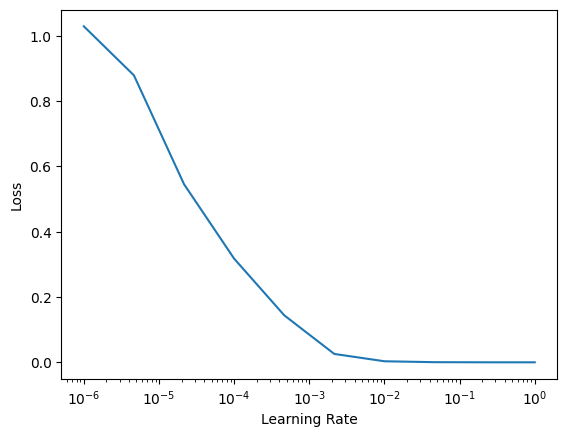

f1 hand
0.896551724137931


In [31]:
import numpy as np
import matplotlib.pyplot as plt

#uncommented the print epoch error, see errors from epoch to epoch
n= [10 ,20, 30]
hand = create_network(n, tanh, tanh)
hand.use(cross_entropy, cross_entropy_prime)


# Define the range of learning rates to explore
learning_rates = np.logspace(-6, 0, num=10)

# Initialize lists to store learning rates and corresponding losses
lr_values = []
loss_values = []

for lr in learning_rates:
    
    # Train your neural network for a few epochs with the current learning rate
    hand.fit(x_train, y_train, 50, lr)
    # Calculate and store the loss/error after each epoch
    loss = hand.epoch_error
    lr_values.append(lr)
    loss_values.append(loss)

# Plot the learning rate vs. loss curve
plt.plot(lr_values, loss_values)
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.xscale('log')
plt.show()


ph=hand.predict(x_test)
# Convert the list of arrays to a numpy array
predicted_ph = np.array([arr[0][0] for arr in ph])
##add threshold
binary_ph = np.where(predicted_ph >= 0.5, 1, 0)
print("f1 hand")
f1 = calculate_f1(y_test, binary_ph)
print(f1)